Import stuff and initialize global parameters.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Flatten, Dense, LSTM, \
    MaxPooling2D
from keras.models import Sequential
from common import extract_training_data_as_stacked, generate_multifile_conc, random_file_gen
from sklearn.metrics import explained_variance_score

IMAGE_SIZE = (64, 64, 3)

Using TensorFlow backend.


In [2]:
video_names = ["20171211-182708258.h264",
               "20171211-183607508.h264",
               "20171211-184640781.h264",
               "20171211-185037299.h264",
               "20171211-191157767.h264"
               ]

csv_names = ["20171211-182708258.csv",
             "20171211-183607508.csv",
             "20171211-184640781.csv",
             "20171211-185037299.csv",
             "20171211-191157767.csv"
             ]

data_gen = generate_multifile_conc(video_names, csv_names, batch_size=500, nr_batches=104)

# Convolutional network
Reading data as bundles and creating initial model.

In [3]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=(64, 64, 12)))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(Flatten())
    model.add(Dense(4, activation='linear'))

    model.compile(loss="mse", optimizer="adam")    
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        3488      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        9248      
__________

In [5]:
history = model.fit_generator(data_gen, steps_per_epoch=104, epochs=10)

Epoch 1/10
104/104 [==============================] - 367s - loss: 0.0403   
Epoch 2/10
104/104 [==============================] - 364s - loss: 0.0228   
Epoch 3/10
104/104 [==============================] - 364s - loss: 0.0075   
Epoch 4/10
104/104 [==============================] - 366s - loss: 0.0019   
Epoch 5/10
104/104 [==============================] - 366s - loss: 8.4446e-04   
Epoch 6/10
104/104 [==============================] - 364s - loss: 5.6323e-04   
Epoch 7/10
104/104 [==============================] - 370s - loss: 3.4127e-04   
Epoch 8/10
104/104 [==============================] - 370s - loss: 2.8299e-04   
Epoch 9/10
104/104 [==============================] - 368s - loss: 2.7231e-04   
Epoch 10/10
104/104 [==============================] - 371s - loss: 1.9411e-04   


In [6]:
test_images, test_labels = extract_training_data_as_stacked("Data/20171029-201639.h264.avi", 
                                                            "Data/20171029-201639.h264.csv", 
                                                            IMAGE_SIZE)

prediction = model.predict(test_images)

### Convolutional network results
Testing prediction printout and graphs.

In [7]:
prediction

array([[ 0.18481965,  0.08975702,  0.81576502],
       [ 0.17658824,  0.0984219 ,  0.81520021],
       [ 0.17432518,  0.09171894,  0.8268528 ],
       ..., 
       [ 0.34776977,  0.03103092,  1.00739229],
       [ 0.05248072,  0.08368357,  0.93067801],
       [-0.34477755,  0.09949024,  0.85000205]], dtype=float32)

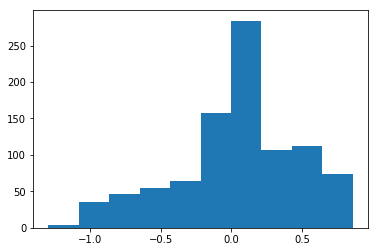

In [8]:
plt.hist(prediction[:, 0])
plt.show()

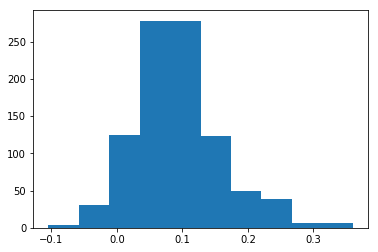

In [9]:
plt.hist(prediction[:, 1])
plt.show()

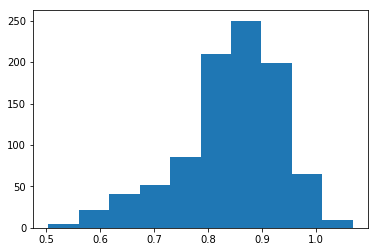

In [10]:
plt.hist(prediction[:, 2])
plt.show()

### Result analysis
Explained variance etc.

Firstly clip incorrect values back into known bounds. Afterwards find the explained variance.

In [11]:
validation_labels = test_labels.as_matrix(columns=test_labels.columns[1: -1])

clipped_prediction = np.zeros_like(prediction)
clipped_prediction[:, 0] = np.clip(prediction[:, 0], -1, 1)
clipped_prediction[:, 1] = np.clip(prediction[:, 1], 0, 1)
clipped_prediction[:, 2] = np.clip(prediction[:, 2], 0, 1)

print(validation_labels.shape)
print(clipped_prediction.shape)

(939, 3)
(939, 3)


In [12]:
explained_variance_score(validation_labels, clipped_prediction)

0.088881589872853925

## K fold cross validation

In [ ]:
from common import run_kfold_cross_val

# Concatenate both videos
total_images = np.concatenate((images, test_images), axis=0)
total_labels = np.concatenate((labels, test_labels), axis=0)

total_y_train = total_labels[:, 1:-1]

results = run_kfold_cross_val(create_model, total_images, total_y_train)
print(results)
print(results.mean())
print(np.median(results))

## Saving model
Saves the model into a file and loads it again.

In [13]:
from keras.models import load_model

model.save('conv_dense.h5')
del model
model = load_model('conv_dense.h5')

Testing out model saving.

In [14]:
prediction = model.predict(test_images)

clipped_prediction = np.zeros_like(prediction)
clipped_prediction[:, 0] = np.clip(prediction[:, 0], -1, 1)
clipped_prediction[:, 1] = np.clip(prediction[:, 1], 0, 1)
clipped_prediction[:, 2] = np.clip(prediction[:, 2], 0, 1)

explained_variance_score(validation_labels, clipped_prediction)

0.10358442480994283

It werks.